#### Modelling

In this notebook, we train a model on the 5utr MPRA data that works for any input size and compare it to the fixed-size model from "Human 5′ UTR design and variant effect prediction from a massively parallel translation assay"

In [1]:
from importlib import reload
import re
import random
random.seed(1337)
import os
import pickle

import numpy as np
np.random.seed(1337)
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import backend as K
from keras.models import load_model

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import model
import utils

Using TensorFlow backend.


### Read in the prepared data

In [12]:
with open("../Data/data_dict.pkl", 'rb') as handle:
    data_dict = pickle.load(handle)

data_df = data_dict["data"]
snv_df = data_dict["snv"]
ptr_df = data_dict["ptr"]

### Encode the data in the required input format

In [31]:
reload(utils)
encoded_data = {}
data_df = utils.extract_tis(data_df, downstream_nt=6, upstream_nt=2, cds_col="context", new_col="tis")
for set_type in data_df["set"].unique():
    df_slice = data_df[data_df["set"] == set_type]
    set_type_dict = {}
    for library in df_slice["library"].unique():
        set_type_dict[library] = utils.encode_df(df_slice[df_slice["library"] == library], tis_col="tis")  
    encoded_data[set_type] = set_type_dict

snv_encoded = {}
snv_df = utils.extract_tis(snv_df, downstream_nt=6, upstream_nt=2, cds_col="context", new_col="tis")
snv_df["library"] = "human"
snv_encoded["snv"] = utils.encode_df(snv_df, col="utr", output_col="hrl", tis_col="tis")
snv_encoded["wt"] = utils.encode_df(snv_df, col="mother", output_col="hrl", tis_col="tis")

ptr_df["library"] = "egfp_unmod_1"
ptr_df = utils.extract_tis(ptr_df, downstream_nt=6, upstream_nt=2, new_col="tis")
ptr_encoded = utils.encode_df(ptr_df, col="utr", output_col=None, variable_len=True, tis_col="tis")

### Instantiate a basic model and train

In [4]:
utr_model = model.create_model_masked_bordered()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [70]:
utr_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq (InputLayer)          (None, None, 4)      0                                            
__________________________________________________________________________________________________
convolution_0 (Conv1D)          (None, None, 128)    4224        input_seq[0][0]                  
__________________________________________________________________________________________________
compute_pad_mask (Lambda)       (None, None)         0           input_seq[0][0]                  
__________________________________________________________________________________________________
apply_pad_mask_0 (Lambda)       (None, None, 128)    0           convolution_0[0][0]              
                                                                 compute_pad_mask[0][0]           
__________

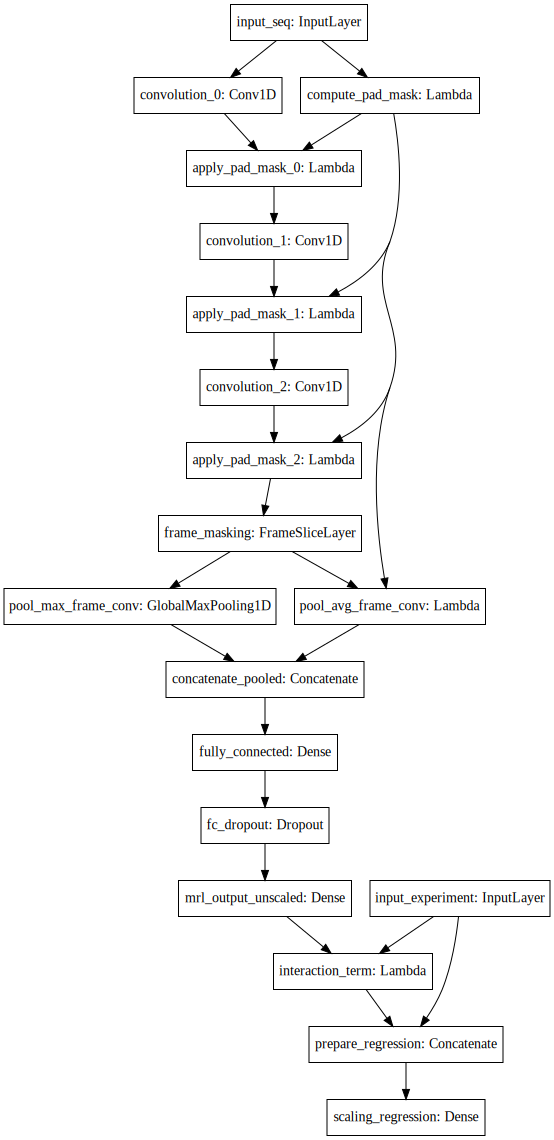

In [73]:
SVG(model_to_dot(utr_model).create(prog='dot', format='svg'))

The architecture is overall very similar to the model in the paper: we first stack three convolutional layers to detect motifs. However, instead of following this by a dense layer directly (which forces the csize to be fixed) we instead use global max and average pooling operations on the convolutional to record which motifs were detected. In order to differentiate in which frame a motif is found, we perform ther pooling operations on each frame seperately. The pooled motif data is then fed into a dense layer. Lastly, we train a scaling regression (which consists simply of estimating interaction terms between the "unscaled mrl" (output of the dense layer) and the library indicator) to avoid having to prenormalize the output data. We can then freeze all layers except this final scaling regression and retrain the regression to adapt the model to the (linear) bias of other libraries.

In [5]:
utils.train(utr_model, encoded_data, libraries=["egfp_unmod_1"], epochs=10, file="basic_model.h5")
utr_model = load_model("basic_model.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 240000 samples, validate on 20000 samples
Epoch 1/10
240000/240000 [==============================] - 46s 190us/step - loss: 2.1368 - val_loss: 0.7529

Epoch 00001: val_loss improved from inf to 0.75293, saving model to basic_model.h5
Epoch 2/10
240000/240000 [==============================] - 27s 112us/step - loss: 1.1072 - val_loss: 0.5164

Epoch 00002: val_loss improved from 0.75293 to 0.51640, saving model to basic_model.h5
Epoch 3/10
240000/240000 [==============================] - 26s 109us/step - loss: 0.8062 - val_loss: 0.3507

Epoch 00003: val_loss improved from 0.51640 to 0.35067, saving model to basic_model.h5
Epoch 4/10
240000/240000 [==============================] - 26s 109us/step - loss: 0.6032 - val_loss: 0.3034

Epoch 00004: val_loss improved from 0.35067 to 0.30342, saving model to basic_model.h5
Epoch 5/10
240000/240000 [=============

In [19]:
pred = utils.evaluate(utr_model, encoded_data, libraries=["egfp_unmod_1"])

Rsquared on set egfp_unmod_1 : 0.9163455006408178, Pearson: 0.9183208437544119


We retrain the scaling regression to the different libraries to account for (linear) library bias

In [8]:
utr_model = utils.retrain_only_scaling(utr_model, encoded_data, libraries=['mcherry_1', 'mcherry_2', 'egfp_unmod_2', 'ga'], batch_size=128, epochs=2)

Epoch 1/2
580244/580244 [==============================] - 29s 50us/step - loss: 4.4942
Epoch 2/2
580244/580244 [==============================] - 28s 49us/step - loss: 0.3789


### Evaluate the model on the validation and test sets

In [20]:
## Validation set performance
utils.evaluate(utr_model, encoded_data, libraries=['egfp_unmod_1', 'mcherry_1', 'mcherry_2', 'egfp_unmod_2', 'human'])

Rsquared on set egfp_unmod_1 : 0.9163455006408178, Pearson: 0.9183208437544119
Rsquared on set mcherry_1 : 0.7298644197431161, Pearson: 0.7378083956616457
Rsquared on set mcherry_2 : 0.757556190335418, Pearson: 0.7743853773884886
Rsquared on set egfp_unmod_2 : 0.8548567809349185, Pearson: 0.8566229008427332
Rsquared on set human : 0.7737906060428292, Pearson: 0.7740032482707502


In [21]:
## Test set performance
utils.evaluate(utr_model, encoded_data, libraries=['egfp_unmod_1', 'mcherry_1', 'mcherry_2', 'egfp_unmod_2'], do_test=True)

Rsquared on set egfp_unmod_1 : 0.9209296221409426, Pearson: 0.9264497251348448
Rsquared on set mcherry_1 : 0.6955460997531262, Pearson: 0.7089517007671915
Rsquared on set mcherry_2 : 0.758614236721261, Pearson: 0.7735984417063653
Rsquared on set egfp_unmod_2 : 0.8524645464901243, Pearson: 0.8529734815686074


The performance is slightly worse but overall similar to the model limited to 50bp presented in the paper. Given that this model has a tighter bottleneck (its dense layer only knows which motives are present, but has no direct information as to their location) in order to tackle a more comprehensive task, this is not too bad. Also, while the 70% for mcherry_1 seems a lot worse than the paper, this may be down to some weird inconsistency between how the mcherry_1 test sets were defined. Because using the model on github, I cannot replicate the 77% claimed in the biorxiv paper either:

In [188]:
paper_model = load_model("../Models/retrained_main_MRL_model.hdf5")
inputs = encoded_data["test"]["mcherry_1"]["seq"]
predictions = paper_model.predict(inputs)
stats.pearsonr(predictions.reshape(-1), encoded_data["test"]["mcherry_1"]["rl"])[0] ** 2

0.6890449813218754

### Additional validation on snv data and in-vivo ptr (protein to mrna ratio) data

In [49]:
utils.eval_snv(utr_model, snv_encoded, snv_df)

Pearson snv : 0.7006297466531879
Pearson wt : 0.5572757134289003
Rsquared fold-change: 0.5296161521706992


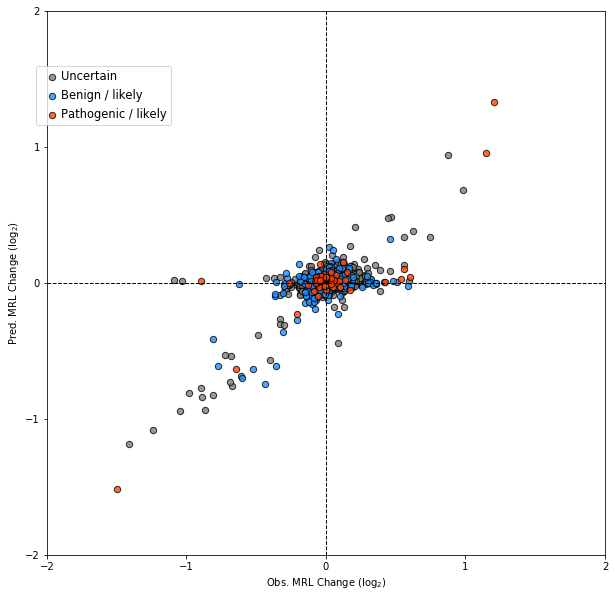

In [50]:
utils.plot_snv(snv_df)

While the r-squared is slightly worse, the plot looks very similar to the one in the paper

PTR Pearson: 0.020850759712858418 p-val: 5.701797237182115e-55


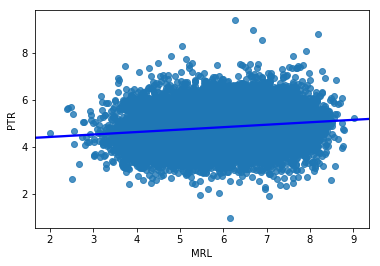

In [74]:
reload(utils)
utils.eval_ptr(utr_model, ptr_encoded, ptr_df)

x = sns.regplot(x='MRL', y="PTR", data=ptr_df, line_kws={"color":"b"}).get_figure()

The PTR (protein to mRNA ratio) data comes from the paper "Quantification and discovery of sequence determinants of protein-per-mRNA amount in 29 human tissues" (Eraslan et al.)

This rsquared of 2% seems quite unimpressive, but, to be fair, the ptr data is (a) very noisy (lots of missing values, averaged over quite different tissues), (b) measures quite a different outcome (as ptr depends not just on ribosome load but also on mrna stability, and thus it is concievable that a lot of the error comes from (i) non-5-utr features or (ii) stability effects counteracting ribosome loading effects (e.g. in frame uAUG impacting stability but not mlr)) and (c) comes from a different cell context than what the model was trained on (so different RBP/trans-acting factors are present in different concentrations etc than what the model expects)
What it does show however, is that the models predictions positively correlate with other measures of translational efficiency. In the notebook "Ribo" I have performed a similar analysis for ribosome profiling data. Again the correlations are limited but positive.

In [66]:
## As comparison, we instead load the model limited to 50bp and check its perfromance on ptr data
paper_model = load_model("../Models/retrained_main_MRL_model.hdf5")

ptr_df_50 = ptr_df.copy()
ptr_df_50["utr"] = ptr_df["utr"].str[-50:]
ptr_encoded_50 = utils.encode_df(ptr_df_50, col="utr", output_col=None, variable_len=True)

In [69]:
inputs = ptr_encoded_50["seq"]
predictions = paper_model.predict(inputs)
ptr_df_50["MRL"] = predictions.reshape(-1)
pearson = utils.pearson_r(ptr_df_50["MRL"],ptr_df_50["PTR"])
print("PTR Pearson: " + str(pearson[0]) + " p-val: " + str(pearson[1]))

PTR Pearson: 0.010355612940373288 p-val: 5.003781844894933e-28


Somewhat unsurprisingly, looking at the whole 5-utr sequence does improve results

In [75]:
utr_model.save("../Models/basic_model_scaled.h5")

### Try fancy architectures

One can attempt to imporve upon the architecture in a variety of ways. However, in general it seems that this does not achieve much, since more complicated architectures tend to also have more ability to adapt to the fixed-size training data (e.g. through larger receptive fields eventually seeing almost the entire input) and as a result generalize less well to variable-sized contexts. Possibly, more constraints could be introduced in order to allow complex architectures to nevertheless generalize

In [207]:
reload(model)
new_model = model.create_model_masked_bordered(n_conv_layers=7, kernel_size=[8,8,3,3,3,3,3,3,3,3], dilations=[1,1,2,4,6,8,16], 
                                               n_filters=32, skip_connections="dense")

In [208]:
utils.train(new_model, encoded_data, libraries=["egfp_unmod_1", "ga"], epochs=20, file="basic_model.h5")

new_model = load_model("basic_model.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})

new_model = utils.retrain_only_scaling(new_model, encoded_data, libraries=["mcherry_1", 'mcherry_2', 'egfp_unmod_2', 'ga'], batch_size=128, epochs=3)

## Validation set performance
utils.evaluate(new_model, encoded_data, libraries=['egfp_unmod_1', 'mcherry_1', 'mcherry_2', 'egfp_unmod_2', 'human'])
## Test set performance
utils.evaluate(new_model, encoded_data, libraries=['egfp_unmod_1', 'mcherry_1', 'mcherry_2', 'egfp_unmod_2'], do_test=True)
## snv performance
utils.eval_snv(new_model, snv_encoded, snv_df)
## ptr performance
utils.eval_ptr(new_model, ptr_encoded, ptr_df)

Train on 265244 samples, validate on 20000 samples
Epoch 1/20
 - 74s - loss: 1.5955 - val_loss: 0.5859

Epoch 00001: val_loss improved from inf to 0.58594, saving model to basic_model.h5
Epoch 2/20
 - 50s - loss: 0.8545 - val_loss: 0.3595

Epoch 00002: val_loss improved from 0.58594 to 0.35954, saving model to basic_model.h5
Epoch 3/20
 - 50s - loss: 0.5844 - val_loss: 0.2711

Epoch 00003: val_loss improved from 0.35954 to 0.27108, saving model to basic_model.h5
Epoch 4/20
 - 50s - loss: 0.4583 - val_loss: 0.2530

Epoch 00004: val_loss improved from 0.27108 to 0.25298, saving model to basic_model.h5
Epoch 5/20
 - 49s - loss: 0.4248 - val_loss: 0.2427

Epoch 00005: val_loss improved from 0.25298 to 0.24272, saving model to basic_model.h5
Epoch 6/20
 - 50s - loss: 0.4113 - val_loss: 0.2380

Epoch 00006: val_loss improved from 0.24272 to 0.23804, saving model to basic_model.h5
Epoch 7/20
 - 51s - loss: 0.3845 - val_loss: 0.2154

Epoch 00007: val_loss improved from 0.23804 to 0.21539, savi

In [217]:
new_model.save("../Models/dense7_dilated_scaled.h5")

In [218]:
new_model = load_model("../Models/dense7_dilated_scaled.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})

### FrameShift validation
To ensure that the frameshift works correctly and allows the model to distinguish between in-frame and out-of-frame motives, we slide a Kozak motif (GCCACCATG) through a random sequence and check the predictions.

In [3]:
base_model = load_model("../Models/basic_model_scaled.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


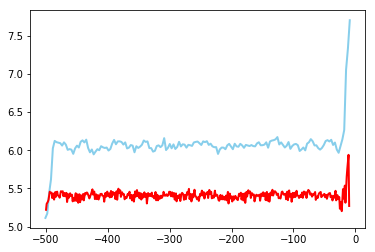

In [5]:
uAUG_pred = utils.check_uAUG_detection(base_model, seq_length=501, samples=100, kozak=True)
utils.uAUG_plot(uAUG_pred)

The blue line, representing in-frame kozak motifs, shows a consistently higher mrl, as we would expect. At the borders, we have somewhat different behaviour. It is not entirely clear if this behaviour is learned or the result of the convolutional filters not being able to detect the motif properly at the border.

### Changed padding to same

In [34]:
reload(model)
new_model = model.create_model_masked_bordered(n_conv_layers=3, 
                        kernel_size=[8,8,8], n_filters=128,
                        padding="same", use_batchnorm=False,
                        skip_connections="")

In [ ]:
utils.train(new_model, encoded_data, libraries=["egfp_unmod_1", "ga"], epochs=20, file="basic_model.h5")

In [39]:
new_model = load_model("basic_model.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})

new_model = utils.retrain_only_scaling(new_model, encoded_data, libraries=["mcherry_1", 'mcherry_2', 'egfp_unmod_2', 'ga'], batch_size=128, epochs=3)

## Validation set performance
utils.evaluate(new_model, encoded_data, libraries=['egfp_unmod_1', 'mcherry_1', 'mcherry_2', 'egfp_unmod_2', 'human'])
## Test set performance
utils.evaluate(new_model, encoded_data, libraries=['egfp_unmod_1', 'mcherry_1', 'mcherry_2', 'egfp_unmod_2'], do_test=True)
## snv performance
utils.eval_snv(new_model, snv_encoded, snv_df)
## ptr performance
utils.eval_ptr(new_model, ptr_encoded, ptr_df)

Epoch 1/3
 - 34s - loss: 3.6798
Epoch 2/3
 - 32s - loss: 0.3573
Epoch 3/3
 - 31s - loss: 0.2826
Rsquared on set egfp_unmod_1 : 0.9196439205744261, Pearson: 0.9198482902035143
Rsquared on set mcherry_1 : 0.7251934929157047, Pearson: 0.7252096157459952
Rsquared on set mcherry_2 : 0.7646669380516886, Pearson: 0.7684385030345778
Rsquared on set egfp_unmod_2 : 0.8662873817941781, Pearson: 0.8687104474215319
Rsquared on set human : 0.8008152024330787, Pearson: 0.8010502743109039
Rsquared on set egfp_unmod_1 : 0.925637602490822, Pearson: 0.9273304322250697
Rsquared on set mcherry_1 : 0.6959505856243182, Pearson: 0.6969570792360299
Rsquared on set mcherry_2 : 0.7627652474664502, Pearson: 0.7684063930675804
Rsquared on set egfp_unmod_2 : 0.8587693309556981, Pearson: 0.8621750129982805
Pearson snv : 0.7525152476375786
Pearson wt : 0.6100476998671412
Rsquared fold-change: 0.5283301745978579
PTR Pearson: 0.02055019595532489 p-val: 3.391840300501331e-54


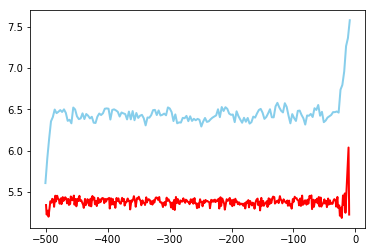

In [38]:
uAUG_pred = utils.check_uAUG_detection(new_model, seq_length=501, samples=100, kozak=True)
utils.uAUG_plot(uAUG_pred)

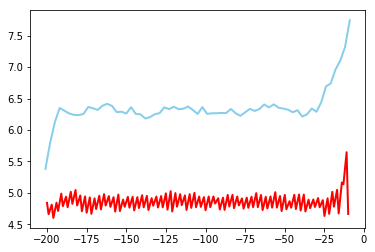

In [42]:
uAUG_pred = utils.check_uAUG_detection(new_model, seq_length=201, samples=100, kozak=True)
utils.uAUG_plot(uAUG_pred)

### With tis

In [ ]:
# explicitly include tis

In [ ]:
utils.train(tis_model, encoded_data, libraries=["egfp_unmod_1", "ga"], epochs=20, file="tis_model.h5", extra_keys=["tis"])

In [33]:
reload(utils)
new_model = load_model("tis_model.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})

new_model = utils.retrain_only_scaling(new_model, encoded_data, libraries=["mcherry_1", 'mcherry_2', 'egfp_unmod_2', 'ga'], 
                                       batch_size=128, epochs=3,extra_keys=["tis"])

## Validation set performance
utils.evaluate(new_model, encoded_data, libraries=['egfp_unmod_1', 'mcherry_1', 'mcherry_2', 'egfp_unmod_2', 'human'],
              extra_keys=["tis"])
## Test set performance
utils.evaluate(new_model, encoded_data, libraries=['egfp_unmod_1', 'mcherry_1', 'mcherry_2', 'egfp_unmod_2'], do_test=True,
              extra_keys=["tis"])
## snv performance
utils.eval_snv(new_model, snv_encoded, snv_df, extra_keys=["tis"])
## ptr performance
utils.eval_ptr(new_model, ptr_encoded, ptr_df, extra_keys=["tis"])

Epoch 1/3
 - 34s - loss: 3.8617
Epoch 2/3
 - 32s - loss: 0.3466
Epoch 3/3
 - 32s - loss: 0.2922
Rsquared on set egfp_unmod_1 : 0.9161539270074304, Pearson: 0.9178569999601706
Rsquared on set mcherry_1 : 0.6732133810751066, Pearson: 0.7213839359273263
Rsquared on set mcherry_2 : 0.7116808935238735, Pearson: 0.7578803201283314
Rsquared on set egfp_unmod_2 : 0.8274167987814964, Pearson: 0.8276791027800402
Rsquared on set human : 0.757251751569419, Pearson: 0.7589782639135434
Rsquared on set egfp_unmod_1 : 0.9198682765431039, Pearson: 0.9237245795878509
Rsquared on set mcherry_1 : 0.6303042830711996, Pearson: 0.6936464552890712
Rsquared on set mcherry_2 : 0.6961807061118966, Pearson: 0.7537067822001695
Rsquared on set egfp_unmod_2 : 0.822495726261941, Pearson: 0.8235892147185514
Pearson snv : 0.7330856833158456
Pearson wt : 0.5922534346587215
Rsquared fold-change: 0.5390008910427765
PTR Pearson: 0.02344511592613961 p-val: 1.157003922944088e-61


In [ ]:
uAUG_pred = utils.check_uAUG_detection(base_model, seq_length=501, samples=100, kozak=True)
utils.uAUG_plot(uAUG_pred)